### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import itertools
from tqdm import tqdm

import statsmodels.api as sm
from scipy.stats import t, f, boxcox, skew, kurtosis, gmean
from statsmodels.stats.diagnostic import linear_reset, het_white

import warnings
warnings.filterwarnings('ignore')

### Обработка

In [2]:
data = pd.read_csv('Data_with_new_feature.csv', encoding='utf-8')

### Логарифм цены

In [3]:
data['log_price'] = np.log(data['price'])
data = data.drop(['price'], axis=1)
y = data['log_price']
X = data.drop(['log_price'], axis=1)

### Регрессоры, которые можно логарифмировать и нет

In [4]:
cols_to_try_log = ['avg_rating', 'tirage', 'cnt_reviews', 'pages_cnt']
unconditional_cols = [x for x in X.columns.tolist() if x not in cols_to_try_log]

In [5]:
def generate_all_combinations(num_of_repeats):
    """Генерирует все комбинации признаков, к которым применяется функциональное преобразование"""
    return product([False, True], repeat=num_of_repeats)

def prepare_X(cols_to_try_func, combination, df, func, flag='stay'):
    """Создает матрицу X для текущей комбинации"""
    """Примеры функций: np.log, np.power, np.reciprocal, ..."""
    X_temp = df[unconditional_cols].copy()
    feature_name = getattr(func, '__name__', repr(func))
    
    for i, col in enumerate(cols_to_try_func): # col = 'tirage'
        if combination[i]:
            try:
                safe_col = df[col]
                if (safe_col <= 0).any() and (func == np.log) or (func == np.reciprocal):
                    safe_col = safe_col + 1e-6
                if flag == 'stay':
                    X_temp[col] = safe_col
                    X_temp[f'{feature_name}_{col}'] = func(safe_col)
                else:
                    X_temp[f'{feature_name}_{col}'] = func(safe_col)
            except Exception as e:
                print(f"Ошибка при применении функции к {col}: {e}")
        else:
            X_temp[col] = df[col]
    
    return sm.add_constant(X_temp)

def getting_statistic(cols_to_try_func, df, func, flag='stay'):
    results = []

    total_combinations = 2 ** len(cols_to_try_func)
    feature_name = getattr(func, '__name__', repr(func))

    for combination in tqdm(generate_all_combinations(num_of_repeats=len(cols_to_try_func)), total=total_combinations):
        try:
            # Подготавливаем данные
            X_curr = prepare_X(cols_to_try_func, combination, df, func, flag=flag)

            model = sm.OLS(df['log_price'], X_curr).fit()
            results.append({
                'combination': combination,
                'aic': model.aic,
                'bic': model.bic,
                'adj_r2': model.rsquared_adj,
            })

        except Exception as e:
            print(f"Error in combination {combination}: {str(e)}")
            continue

    df_results = pd.DataFrame(results)

    df_results[f'{feature_name}_columns'] = df_results['combination'].apply(
        lambda x: [cols_to_try_func[i] for i, my_func in enumerate(x) if my_func]
    )
    
    return df_results

In [6]:
def custom_func(x):
    return x**2

In [7]:
my_func = np.log
data_frame = getting_statistic(cols_to_try_func=cols_to_try_log, df=data, func=my_func, flag='')

best_aic = data_frame.loc[data_frame['aic'].idxmin()]
best_bic = data_frame.loc[data_frame['bic'].idxmin()]
best_adj_r2 = data_frame.loc[data_frame['adj_r2'].idxmax()]

print("Лучшая модель по AIC:")
print(f"Логарифмированные переменные: {best_aic[f'{my_func.__name__}_columns']}")
print(f"AIC: {best_aic['aic']:.2f}\n")

print("Лучшая модель по BIC:")
print(f"Логарифмированные переменные: {best_bic[f'{my_func.__name__}_columns']}")
print(f"BIC: {best_bic['bic']:.2f}\n")

print("Лучшая модель по Adj.R²:")
print(f"Логарифмированные переменные: {best_adj_r2[f'{my_func.__name__}_columns']}")
print(f"Adj.R²: {best_adj_r2['adj_r2']:.4f}")

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 123.43it/s]

Лучшая модель по AIC:
Логарифмированные переменные: ['tirage']
AIC: 514.64

Лучшая модель по BIC:
Логарифмированные переменные: ['tirage']
BIC: 599.59

Лучшая модель по Adj.R²:
Логарифмированные переменные: ['tirage']
Adj.R²: 0.7287


**Вывод:** нужно логарифмировать тираж; Adj R^2 = 0.6062

**Логарифмирование тиража:**

In [8]:
upd_data = data.copy()
upd_data['log_tirage'] = np.log(upd_data['tirage'])
upd_data = upd_data.drop(['tirage'], axis=1)
upd_data.head()

,const,avg_rating,cnt_reviews,pages_cnt,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,log_price,log_tirage
0,1.0,4.1,925,512,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,5.743003,10.308953
1,1.0,4.1,1341,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,5.743003,10.308953
2,1.0,4.5,363,192,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0,5.648974,10.126631
3,1.0,4.3,872,288,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0,5.826000,9.392662
4,1.0,4.2,3004,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,5.648974,10.308953


In [9]:
X_upd = upd_data.drop(['log_price'], axis=1)

In [10]:
X_upd

,const,avg_rating,cnt_reviews,pages_cnt,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,log_tirage
0,1.0,4.1,925,512,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,10.308953
1,1.0,4.1,1341,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,10.308953
2,1.0,4.5,363,192,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0,10.126631
3,1.0,4.3,872,288,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0,9.392662
4,1.0,4.2,3004,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,10.308953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1.0,5.0,3,624,0.0,0.0,0.0,1.0,1.0,1.538462,0.0,0.0,1.0,7.313220
3186,1.0,3.7,53,448,0.0,0.0,0.0,1.0,1.0,1.696429,0.0,0.0,1.0,7.313220
3187,1.0,4.3,42,784,0.0,0.0,1.0,0.0,1.0,1.096939,0.0,0.0,1.0,8.006368
3188,1.0,3.8,29,704,0.0,0.0,0.0,1.0,1.0,0.906250,0.0,0.0,1.0,7.600902


In [11]:
# cols_to_try_log_ = ['avg_rating', 'cnt_reviews', 'pages_cnt']
# unconditional_cols_ = [x for x in X_try.columns.tolist() if x not in cols_to_try_log_]

Также функции будут работать, если мы решим проверить какие-то кастомные функции типо этого:

### Итоговая модель с ln Y

После проверки всех функциональных форм обучаем итоговую модель:

In [12]:
log_model = sm.OLS(data['log_price'], X_upd).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     660.0
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        20:56:24   Log-Likelihood:                -243.32
No. Observations:                3190   AIC:                             514.6
Df Residuals:                    3176   BIC:                             599.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

# Тест Рамсея

In [13]:
reset_result = linear_reset(log_model, power=2)

print("RESET test (Ramsey)")
print(reset_result)

RESET test (Ramsey)
<Wald test (chi2): statistic=372.89813979260447, p-value=4.377093274368732e-83, df_denom=1>


**Вывод:** отвергаем H0 ==> нужно добавить степени

In [14]:
X_ramsey = X_upd.copy()
X_ramsey['Y_hat^2'] = log_model.fittedvalues**2
X_ramsey['Y_hat^3'] = log_model.fittedvalues**3
X_ramsey['Y_hat^4'] = log_model.fittedvalues**4
X_ramsey['Y_hat^5'] = log_model.fittedvalues**5

In [15]:
log_model = sm.OLS(data['log_price'], X_ramsey).fit()
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     816.9
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        20:56:24   Log-Likelihood:                 352.50
No. Observations:                3190   AIC:                            -669.0
Df Residuals:                    3172   BIC:                            -559.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [16]:
reset_result = linear_reset(log_model, power=2)

print("RESET test (Ramsey)")
print(reset_result)

RESET test (Ramsey)
<Wald test (chi2): statistic=264.12922872221327, p-value=2.160078767577537e-59, df_denom=1>


In [17]:
# Тест Уайта
residuals = log_model.resid
white_test = het_white(residuals, X_upd)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

LM-статистика: 848.6984837153504
p-value для LM-статистики: 2.9394585033309365e-125
F-статистика: 12.924644926645406
p-value для F-статистики: 1.3749319296491597e-149
Гетероскедастичность выявлена.


In [18]:
# Тест Глейзера
abs_residuals = np.abs(residuals)
glejser_model = sm.OLS(abs_residuals, X_upd).fit()

p_values = glejser_model.pvalues
# print(f"P-значения:")
# if p_values[0]:
#     print(p_values)
if any(p < 0.05 for p in p_values[1:]):
    print("Есть признаки гетероскедастичности.")
else:
    print("Нет признаков гетероскедастичности.")

Есть признаки гетероскедастичности.


In [23]:
data_sorted = data.sort_values(by='cover_type_Твёрдый_переплёт', ascending=True).reset_index(drop=True)
last_soft_index = data_sorted[data_sorted['cover_type_Твёрдый_переплёт'] == 0].index[-1]
print("Последний индекс с мягкой обложкой (0):", last_soft_index)
data_sorted

Последний индекс с мягкой обложкой (0): 1518


,const,avg_rating,cnt_reviews,pages_cnt,tirage,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,log_price
0,1.0,4.1,925,512,30000,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,5.743003
1,1.0,5.0,2,352,4000,0.0,1.0,0.0,0.0,0.0,0.511364,0.0,0.0,1.0,5.713733
2,1.0,4.5,65,352,4000,0.0,0.0,0.0,1.0,0.0,0.482955,1.0,0.0,1.0,5.680173
3,1.0,4.1,31,416,3000,1.0,0.0,0.0,0.0,0.0,0.502404,0.0,0.0,0.0,5.648974
4,1.0,4.3,69,352,3000,0.0,1.0,0.0,0.0,0.0,0.482955,0.0,0.0,1.0,5.700444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1.0,4.8,12,352,3000,1.0,0.0,0.0,0.0,1.0,0.880682,0.0,1.0,0.0,6.466145
3186,1.0,4.2,317,544,3000,0.0,0.0,1.0,0.0,1.0,1.231618,1.0,0.0,1.0,6.963190
3187,1.0,4.9,10,544,3000,0.0,0.0,1.0,0.0,1.0,0.937500,1.0,0.0,1.0,6.660575
3188,1.0,4.9,17,896,4000,0.0,1.0,0.0,0.0,1.0,1.160714,1.0,0.0,1.0,7.123673


In [22]:
data_sorted.columns

Index(['const', 'avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage',
       'publisher_АСТ', 'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Эксмо', 'cover_type_Твёрдый_переплёт', 'weight/page_cnt',
       '2024_or_2025', '6-', '16+', 'log_price'],
      dtype='object')

### Тест Чоу

Одной из причин гетероскедастичности может быть факт разнородности данных. Для того, чтобы проверить, в этом ли проблема, проведем тест Чоу.

**Выбор бинарной переменной для деления данных и проведения теста Чоу.**<br>

Тип обложки (твёрдая или мягкая) является возможным источником потенциальной разнородности. Книги в твёрдом переплёте, как правило, позиционируются как более премиальный продукт: они дороже в производстве, дольше служат и часто сопровождаются более высоким качеством бумаги и печати. Цена таких изданий формируется иначе, чем у книг в мягкой обложке, где ключевым фактором становится доступность и массовость. Это различие может приводить к тому, что одни и те же характеристики (например, объём, рейтинг или тираж) по-разному влияют на цену в зависимости от типа обложки. Кроме того, дисперсия ошибок модели может отличаться: для твёрдых обложек разброс цен может быть выше из-за большего диапазона качества и маркетинговых стратегий. В связи с этим деление выборки по типу обложки обосновано как с точки зрения различий в структуре ценообразования, так и возможной гетероскедастичности между группами.

Составим три модели:

\begin{align*}
\textbf{(1) } \ln(\text{price}_i) &= \beta_1 + \beta_2 \cdot \text{avg_rating}_i + \beta_3 \cdot \text{cnt_reviews}_i + \beta_4 \cdot \text{pages_cnt}_i + \beta_5 \cdot \text{tirage}_i \\
&\quad + \beta_6 \cdot \text{publisher_АСТ}_i + \beta_7 \cdot \text{publisher_Азбука}_i + \beta_8 \cdot \text{publisher_Иностранка}_i + \beta_9 \cdot \text{publisher_Эксмо}_i \\
&\quad + \beta_{10} \cdot \text{cover_type_Твёрдый_переплёт}_i + \beta_{11} \cdot \left( \frac{\text{weight}}{\text{page_cnt}} \right)_i + \beta_{12} \cdot \text{2024_or_2025}_i \\
&\quad + \beta_{13} \cdot \text{6-}_i + \beta_{14} \cdot \text{16+}_i, \quad \text{где } i = 0, \dots, 1518
\end{align*}

\begin{align*}
\textbf{(2) } \ln(\text{price}_j) &= \alpha_1 + \alpha_2 \cdot \text{avg_rating}_j + \alpha_3 \cdot \text{cnt_reviews}_j + \alpha_4 \cdot \text{pages_cnt}_j + \alpha_5 \cdot \text{tirage}_j \\
&\quad + \alpha_6 \cdot \text{publisher_АСТ}_j + \alpha_7 \cdot \text{publisher_Азбука}_j + \alpha_8 \cdot \text{publisher_Иностранка}_j + \alpha_9 \cdot \text{publisher_Эксмо}_j \\
&\quad + \alpha_{10} \cdot \text{cover_type_Твёрдый_переплёт}_j + \alpha_{11} \cdot \left( \frac{\text{weight}}{\text{page_cnt}} \right)_j + \alpha_{12} \cdot \text{2024_or_2025}_j \\
&\quad + \alpha_{13} \cdot \text{6-}_j + \alpha_{14} \cdot \text{16+}_j, \quad \text{где } j = 1519, \dots, 3189
\end{align*}

\begin{align*}
\textbf{(3) } \ln(\text{price}_a) &= \gamma_1 + \gamma_2 \cdot \text{avg_rating}_a + \gamma_3 \cdot \text{cnt_reviews}_a + \gamma_4 \cdot \text{pages_cnt}_a + \gamma_5 \cdot \text{tirage}_a \\
&\quad + \gamma_6 \cdot \text{publisher_АСТ}_a + \gamma_7 \cdot \text{publisher_Азбука}_a + \gamma_8 \cdot \text{publisher_Иностранка}_a + \gamma_9 \cdot \text{publisher_Эксмо}_a \\
&\quad + \gamma_{10} \cdot \text{cover_type_Твёрдый_переплёт}_a + \gamma_{11} \cdot \left( \frac{\text{weight}}{\text{page_cnt}} \right)_a + \gamma_{12} \cdot \text{2024_or_2025}_a \\
&\quad + \gamma_{13} \cdot \text{6-}_a + \gamma_{14} \cdot \text{16+}_a, \quad \text{где } a = 0, \dots, 3189
\end{align*}



Далее надо проверить гипотезу:
$
H_{0}: \beta = \alpha \\
H_{1}: \sum_{i=1}^{14} |\beta_i - \alpha_i| > 0 
$

In [28]:
X_soft_cover = data_sorted[data_sorted['cover_type_Твёрдый_переплёт'] == 0]
X_hard_cover = data_sorted[data_sorted['cover_type_Твёрдый_переплёт'] == 1]

X_no_cover = X_upd.drop(columns=["cover_type_Твёрдый_переплёт"])

model_R = sm.OLS(y, X_no_cover).fit()
RSS_R = sum(model_R.resid**2)

X_M = X_upd[X_upd["cover_type_Твёрдый_переплёт"] == 0].drop(columns=["cover_type_Твёрдый_переплёт"])
y_soft_cover = y[X_upd["cover_type_Твёрдый_переплёт"] == 0]
model_M = sm.OLS(y_soft_cover, X_M).fit()
RSS_M = sum(model_M.resid**2)

X_F = X_upd[X_upd["cover_type_Твёрдый_переплёт"] == 1].drop(columns=["cover_type_Твёрдый_переплёт"])
y_hard_cover = y[X_upd["cover_type_Твёрдый_переплёт"] == 1]
model_F = sm.OLS(y_hard_cover, X_F).fit()
RSS_F = sum(model_F.resid**2)

k_R = X_no_cover.shape[1]
n = X_no_cover.shape[0]

F_stat = ((RSS_R - (RSS_M + RSS_F)) / k_R) / ((RSS_M + RSS_F) / (n - 2*k_R))

print(f"F-статистика: {F_stat}")

p_value = 1 - f.cdf(F_stat, k_R, n - 2*k_R)
print(f'Значение p-value: {p_value}')


F-статистика: 83.86414867909902
Значение p-value: 1.1102230246251565e-16


**Вывод:** `p-value` близок к 0, что говорит об отсутствии оснований отвергнуть нулевую гипотезу. То есть данные предполагаемой разнородности по типу обложки нет.

## Попытки убрать гетероскедастичность:

In [29]:
X = sm.add_constant(data.drop(columns='log_price'))
y = data['log_price']

ols_model = sm.OLS(y, X).fit()
residuals = ols_model.resid

for col in data.columns.drop('log_price').drop('const'):
    X_j = sm.add_constant(data[[col]])
    model = sm.OLS(np.abs(residuals), X_j).fit()
    print(f"{col} p-value = {round(model.pvalues[1], 4)}")

avg_rating p-value = 0.2058
cnt_reviews p-value = 0.0719
pages_cnt p-value = 0.0
tirage p-value = 0.0
publisher_АСТ p-value = 0.0
publisher_Азбука p-value = 0.0
publisher_Иностранка p-value = 0.0
publisher_Эксмо p-value = 0.0
cover_type_Твёрдый_переплёт p-value = 0.0
weight/page_cnt p-value = 0.0
2024_or_2025 p-value = 0.3753
6- p-value = 0.0031
16+ p-value = 0.0208


## 1) Реализация WLS:

In [30]:
log_model = sm.OLS(data['log_price'], X_upd).fit()
resid = log_model.resid

In [31]:
# вспомогательная модель, записанная через модуль - не помогла
aux_model_1 = sm.OLS(np.abs(resid), X_upd).fit()
sigma_hat_1 = aux_model_1.fittedvalues

y_wls_1 = data['log_price'] / sigma_hat_1
X_wls_1 = X.divide(sigma_hat_1, axis=0)

`Актуально и для FGLS:`<br>
Если предполагается, что дисперсия ошибки зависит от уровня прогнозируемого значения (например, остатки растут с увеличением `y_hat`), то надо использовать такую вспомогательную модель:
* aux_model = sm.OLS(np.abs(resid), sm.add_constant(y_pred)).fit()

Более общей вспомогательной моделью является:
* aux_model_1 = sm.OLS(np.abs(resid), X_upd).fit()


In [32]:
# тогда попробуем вспомогательную модель, записанную через квадрат
aux_model_2 = sm.OLS(resid ** 2, X_upd).fit()
sigma_hat_2 = aux_model_2.fittedvalues

y_wls_2 = data['log_price'] / sigma_hat_2
X_wls_2 = X.divide(sigma_hat_2, axis=0)

In [33]:
# y_new = data['log_price'] / sigma_hat_1
# quantitative_feature = ['avg_rating', 'log_tirage', 'cnt_reviews', 'pages_cnt', 'weight/page_cnt']
# X_upd[quantitative_feature] = X_upd[quantitative_feature].div(sigma_hat_1, axis=0)
wls_like_model = sm.OLS(y_wls_1, X_wls_1).fit() # надо изменить weights на weights_1 / weights_2

In [34]:
X_upd

,const,avg_rating,cnt_reviews,pages_cnt,publisher_АСТ,publisher_Азбука,publisher_Иностранка,publisher_Эксмо,cover_type_Твёрдый_переплёт,weight/page_cnt,2024_or_2025,6-,16+,log_tirage
0,1.0,4.1,925,512,1.0,0.0,0.0,0.0,0.0,0.488281,1.0,0.0,1.0,10.308953
1,1.0,4.1,1341,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,10.308953
2,1.0,4.5,363,192,1.0,0.0,0.0,0.0,0.0,0.687500,1.0,0.0,1.0,10.126631
3,1.0,4.3,872,288,1.0,0.0,0.0,0.0,0.0,0.725694,1.0,0.0,1.0,9.392662
4,1.0,4.2,3004,320,1.0,0.0,0.0,0.0,0.0,0.625000,1.0,0.0,1.0,10.308953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1.0,5.0,3,624,0.0,0.0,0.0,1.0,1.0,1.538462,0.0,0.0,1.0,7.313220
3186,1.0,3.7,53,448,0.0,0.0,0.0,1.0,1.0,1.696429,0.0,0.0,1.0,7.313220
3187,1.0,4.3,42,784,0.0,0.0,1.0,0.0,1.0,1.096939,0.0,0.0,1.0,8.006368
3188,1.0,3.8,29,704,0.0,0.0,0.0,1.0,1.0,0.906250,0.0,0.0,1.0,7.600902


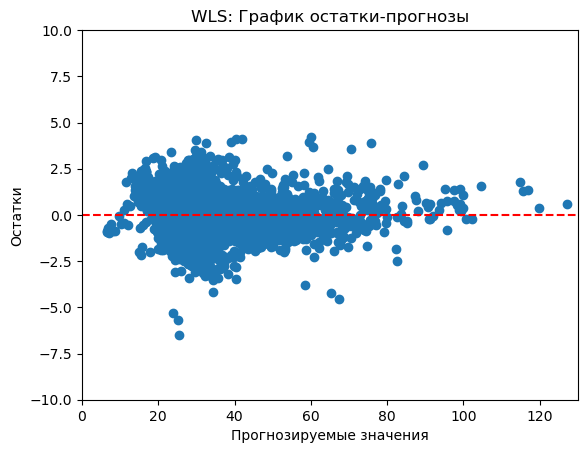

In [35]:
# Визуальный анализ (для обоих вспомогательных моделей что-то не то получается)
wls_residuals = wls_like_model.resid
fitted_values_ln_y = wls_like_model.fittedvalues

plt.scatter(fitted_values_ln_y, wls_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlim(xmax=130, xmin=0)
plt.ylim(ymax=10, ymin=-10)
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('WLS: График остатки-прогнозы')
plt.show()

In [36]:
# Sigma = np.diag(sigma_hat_1**2)
# Sigma_df = pd.DataFrame(Sigma, index=data.index, columns=data.index)
# Sigma_df

## 2) Имплементация робастных ошибок в форме Уайта:

* `HC0` — классический White

* `HC1` — скорректированный White (умножается на n/(n−k))

* `HC2`, `HC3` — ещё более устойчивые, особенно при небольших выборках

При наличии в выборке выбросов – наблюдений, сильно
отличающихся от остальных, используют поправки:
* **`HC2`**
* **`HC3`**
<br>

Исследования показывают, что на конечных выборках
**`HC2`** и **`HС3`** дают более точные результаты, чем **`HC1`**.

In [37]:
log_model_robust = sm.OLS(data['log_price'], X_upd).fit(cov_type='HC2')

print(log_model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     1074.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        21:28:42   Log-Likelihood:                -243.32
No. Observations:                3190   AIC:                             514.6
Df Residuals:                    3176   BIC:                             599.6
Df Model:                          13                                         
Covariance Type:                  HC2                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## 3) Реализуем FGLS

По **теореме Айткена** оценка `ОМНК` явялется несмещенной и эффективной, то есть имеет наименьшую ковариационную матрицу в классе всех несмещенных и линейных по `y` оценок.

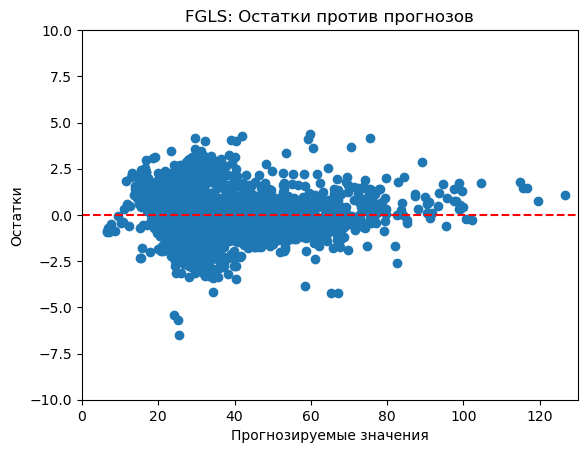

In [38]:
log_model = sm.OLS(data['log_price'], X_upd).fit()
resid = log_model.resid

aux_model = sm.OLS(np.abs(resid), X_upd).fit()
sigma_hat = aux_model.fittedvalues

y_fgls = data['log_price'] / sigma_hat
X_fgls = X_upd.copy()
X_fgls = X_fgls.div(sigma_hat, axis=0)

fgls_model = sm.OLS(y_fgls, X_fgls).fit()

plt.scatter(fgls_model.fittedvalues, fgls_model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlim(xmax=130, xmin=0)
plt.ylim(ymax=10, ymin=-10)
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('FGLS: Остатки против прогнозов')
plt.show()


In [39]:
fgls_model.fittedvalues

0       36.263954
1       38.587041
2       33.398653
3       38.421537
4       67.170338
          ...    
3185    17.077442
3186    15.717832
3187    63.403022
3188    22.226582
3189    34.301489
Length: 3190, dtype: float64

In [40]:
# Sigma = np.diag(sigma_hat**2)
# Sigma_df = pd.DataFrame(Sigma, index=data.index, columns=data.index)
# Sigma_df

In [41]:
print(fgls_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.051e+07
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        21:28:42   Log-Likelihood:                -5609.3
No. Observations:                3190   AIC:                         1.125e+04
Df Residuals:                    3176   BIC:                         1.133e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [42]:
# Тест Уайта
X_fgls_for_test = sm.add_constant(X_fgls, has_constant='add')
residuals = fgls_model.resid
white_test = het_white(residuals, X_fgls_for_test)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

LM-статистика: 2955.919068443635
p-value для LM-статистики: 0.0
F-статистика: 450.24514951230987
p-value для F-статистики: 0.0
Гетероскедастичность выявлена.
